In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the RiverAtlas Shapefile
shapefile_path = "data/HydroRIVERS_v10_shp/reduced_HydroRIVERS_v10.shp"

df = gpd.read_file(shapefile_path)
df.head()

,HYRIV_ID,NEXT_DOWN,MAIN_RIV,LENGTH_KM,DIST_DN_KM,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,ORD_STRA,ORD_CLAS,ORD_FLOW,HYBAS_L12,geometry
0,10004164,10004139,10000855,0.97,195.7,37.6,1.39,497.4,0,0.0,3,2,10,1120086380,"LINESTRING (5.29375 35.99792, 5.28958 36.00208..."
1,10004361,10004164,10000855,4.11,196.8,36.4,13.21,385.3,0,0.0,3,2,10,1120086550,"LINESTRING (5.30625 35.96458, 5.30208 35.96875..."
2,10004434,10004361,10000855,2.65,200.8,32.5,13.90,333.3,0,0.0,3,2,10,1120086550,"LINESTRING (5.32292 35.95208, 5.32292 35.96042..."
3,10004553,0,10004553,2.32,0.0,54.6,6.08,773.7,1,0.0,3,1,10,1120086910,"LINESTRING (5.78125 35.92292, 5.78958 35.93125..."
4,10004670,10004553,10004553,7.48,2.5,52.3,55.28,755.1,1,0.0,3,1,10,1120086910,"LINESTRING (5.71042 35.90208, 5.71458 35.90625..."


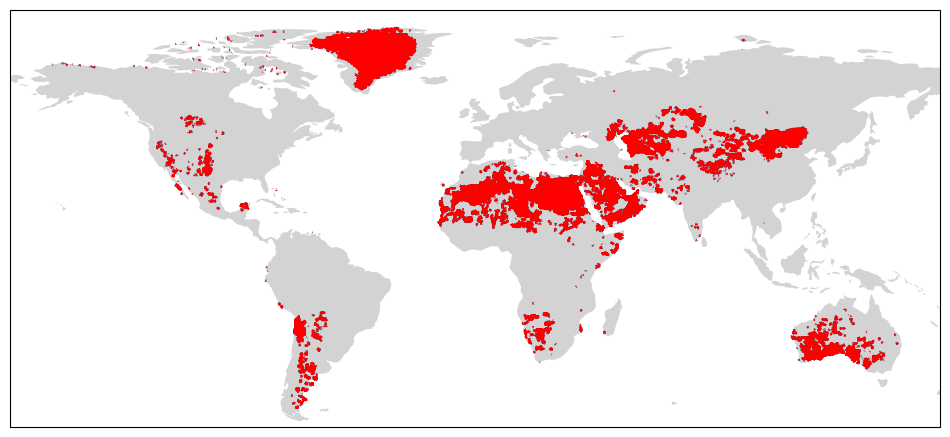

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a figure and subplot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add land and ocean background
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Plot the RiverAtlas data
df.plot(ax=ax)
# Plot the RiverAtlas data
df.plot(color='red',ax=ax)

# Display the plot
plt.show()

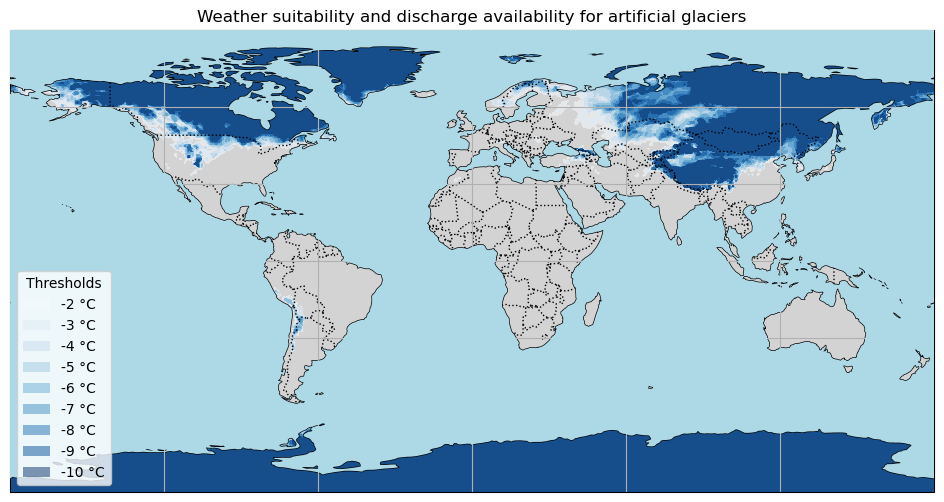

In [5]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load the netCDF file
year = '2019'
dataset = xr.open_dataset('../data/wettasmin_W5E5v2.0_'+year+'.nc')
var = 'wet_temperature'

# Set the window size
window_size = 60

# Extract the necessary variables
lat = dataset['lat']
lon = dataset['lon']
temperature = dataset[var]

# Filter the dataset to the year 2001
year_dataset = dataset.sel(time=year)[var]

# Define the threshold range
thresholds = np.arange(-2, -11, -1)

# Create a figure and subplot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add land and ocean background
ax.add_feature(cfeature.LAND, facecolor='lightgray')



# Iterate over each threshold and plot filled contour regions
for i in range(len(thresholds)):
    threshold = thresholds[i]
    mask = year_dataset < threshold
    
    # Apply consecutive days condition
    consecutive_days = np.zeros_like(mask, dtype=int)
    consecutive_days[0] = mask[0].astype(int)
    
    for t in range(1, len(mask)):
        consecutive_days[t] = mask[t].astype(int) * (consecutive_days[t-1] + 1)
    
    mask_consecutive = consecutive_days >= window_size
    
    mask_2d = np.any(mask_consecutive, axis=0)
    
    ax.contourf(lon, lat, mask_2d, levels=[0.5, 1], colors=[plt.cm.Blues(i / (len(thresholds) - 1)), 'none'], alpha=0.5, hatches=[None, '////'], transform=ccrs.PlateCarree(), zorder=1)

# Add country outlines
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')

# Plot water-stressed regions as a background
#ax.add_geometries(df['geometry'], crs=ccrs.PlateCarree(), facecolor='red', zorder=2)

# Plot the RiverAtlas data
#df.plot(color='red',ax=ax, zorder=2)

# Set the plot extent to cover the entire world
ax.set_global()
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=3)

# Set plot title and labels
ax.set_title('Weather suitability and discharge availability for artificial glaciers')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add map features
ax.coastlines()
ax.gridlines()

# Create a custom legend
threshold_labels = [str(threshold) + ' °C' for threshold in thresholds]
legend_handles = [mpatches.Rectangle((0, 0), 1, 1, fc=plt.cm.Blues(i / (len(thresholds) - 1)), alpha=0.5) for i in range(len(thresholds))]
#no_discharge_handle = mpatches.Patch(color='red', label='No discharge')

# Append the "No discharge" handle to the legend_handles list
#legend_handles.append(no_discharge_handle)

ax.legend(legend_handles, threshold_labels + ['No discharge'], title='Thresholds', loc='lower left')

# Save the figure
plt.savefig("../figs/wetbulb_layer.png", bbox_inches="tight", dpi=300)

# Show the plot
plt.show()

In [4]:
# Load the mountains shapefile
mountains_shapefile = 'data/K3Binary/k3binary.shp'
mountains = gpd.read_file(mountains_shapefile)

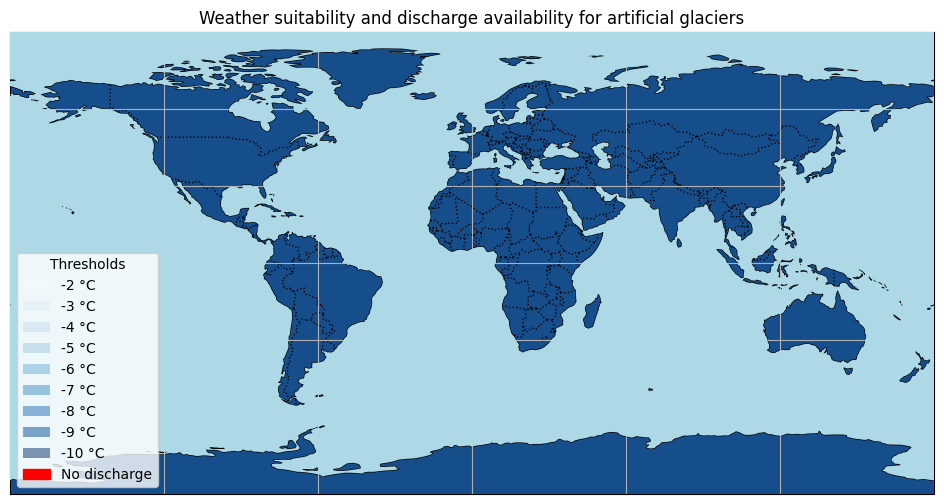

In [7]:

# Extract the necessary variables
lat = dataset['lat']
lon = dataset['lon']
temperature = dataset[var]

# Filter the dataset to the year 2001
year_dataset = dataset.sel(time=year)[var]

# Define the threshold range
thresholds = np.arange(-2, -11, -1)

# Create a figure and subplot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add land and ocean background
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Create a mask for mountain regions
mountain_mask = np.zeros_like(year_dataset, dtype=bool)
for geom in mountains['geometry']:
    lon_idx, lat_idx = np.where((lon == geom.centroid.x) & (lat == geom.centroid.y))
    mountain_mask[:, lat_idx, lon_idx] = True

# Iterate over each threshold and plot filled contour regions
for i in range(len(thresholds)):
    threshold = thresholds[i]
    mask = year_dataset < threshold

    # Apply consecutive days condition
    consecutive_days = np.zeros_like(mask, dtype=int)
    consecutive_days[0] = mask[0].astype(int)

    for t in range(1, len(mask)):
        consecutive_days[t] = mask[t].astype(int) * (consecutive_days[t-1] + 1)

    mask_consecutive = consecutive_days >= window_size

    mask_2d = np.any(mask_consecutive, axis=0)

    # Apply mountain mask
    mask_2d[~mountain_mask[0]] = np.nan  # Set regions not in mountain mask to transparent

    ax.contourf(lon, lat, mask_2d, levels=[0.5, 1], colors=[plt.cm.Blues(i / (len(thresholds) - 1)), 'none'], alpha=0.5, hatches=[None, '////'], transform=ccrs.PlateCarree(), zorder=1)

# Add country outlines
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')

# Set the plot extent to cover the entire world
ax.set_global()
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=3)

# Set plot title and labels
ax.set_title('Weather suitability and discharge availability for artificial glaciers')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add map features
ax.coastlines()
ax.gridlines()

# Create a custom legend
threshold_labels = [str(threshold) + ' °C' for threshold in thresholds]
legend_handles = [mpatches.Rectangle((0, 0), 1, 1, fc=plt.cm.Blues(i / (len(thresholds) - 1)), alpha=0.5) for i in range(len(thresholds))]
no_discharge_handle = mpatches.Patch(color='red', label='No discharge')

# Append the "No discharge" handle to the legend_handles list
legend_handles.append(no_discharge_handle)

ax.legend(legend_handles, threshold_labels + ['No discharge'], title='Thresholds', loc='lower left')

# Save the figure
plt.savefig("figs/wetbulb_dis_layer.png", bbox_inches="tight", dpi=300)

# Show the plot
plt.show()